# Data Exploration
## for covid-19 cases and deaths + hospital capacity data
first let's confirm the correct libraries are installed. For more information on how to set-up your Jupyter Notebook check out the `README.md`

In [ ]:
# author:Szymon Sarnowicz
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
import importlib

def install_if_not_exists(module_names):
    for module_name in module_names:
      try:
          importlib.import_module(module_name)
          print(f"{module_name} is already installed.")
      except ImportError:
          %pip install {module_name}
          print(f"{module_name} has been installed.")

In [163]:
required_modules = ["pandas", "matplotlib", "seaborn", "numpy", "scipy", "IPython", "scikit-learn"]
install_if_not_exists(required_modules)

pandas is already installed.
matplotlib is already installed.
seaborn is already installed.
numpy is already installed.
scipy is already installed.
IPython is already installed.
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 1.4 MB/s eta 0:00:08
    --------------------------------------- 0.2/10.6 MB 2.6 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/10.6 MB 4.4 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.6 MB 6.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/10.6 MB 6.6 MB/s eta 0:00:02
   -------- ------------------------------- 2.2/10.6 MB 8.4 MB/s eta 0:00:01
   ---------- ----------------------------- 2.8/10.6 MB 8.8 MB/s eta 0:00:01
   ------------ --------------------------- 3.3/10.6 MB 9.4 MB/s eta 0:00:01
   ------------- -------------------------- 3.5/10.6 MB 8.6 MB/s eta 0:00:01
   --------------- ------------------------ 4.0/10.6 MB 8.8

In [308]:
import os
import inspect
from itertools import repeat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore, shapiro
from scipy.optimize import curve_fit
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Enable inline plotting in Jupyter notebook
%matplotlib inline

In [6]:
data_deaths = "data/Weekly_United_States_COVID-19_Cases_and_Deaths_by_County_-_ARCHIVED_20240113.csv"
data_hosp = "data/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility_20240114.csv"

In [7]:
df_d = pd.read_csv(data_deaths)
df_h = pd.read_csv(data_hosp)

C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\420344896.py:2: DtypeWarning: Columns (0,3,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_h = pd.read_csv(data_hosp)


In [8]:
df_d.shape

(566056, 9)

In [9]:
df_h.shape

(486943, 128)

In [10]:
list(df_d.columns)

['fips_code',
 'county',
 'state',
 'state_fips',
 'date',
 'cumulative_cases',
 'cumulative_deaths',
 'New cases',
 'New deaths']

In [11]:
list(df_h.columns)

['hospital_pk',
 'collection_week',
 'state',
 'ccn',
 'hospital_name',
 'address',
 'city',
 'zip',
 'hospital_subtype',
 'fips_code',
 'is_metro_micro',
 'total_beds_7_day_avg',
 'all_adult_hospital_beds_7_day_avg',
 'all_adult_hospital_inpatient_beds_7_day_avg',
 'inpatient_beds_used_7_day_avg',
 'all_adult_hospital_inpatient_bed_occupied_7_day_avg',
 'inpatient_beds_used_covid_7_day_avg',
 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
 'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
 'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg',
 'inpatient_beds_7_day_avg',
 'total_icu_beds_7_day_avg',
 'total_staffed_adult_icu_beds_7_day_avg',
 'icu_beds_used_7_day_avg',
 'staffed_adult_icu_bed_occupancy_7_day_avg',
 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg',
 'staffed_icu_adult_patients_confirmed_covid_7_day_avg',
 'total_p

In [12]:
# might be good for later mapping data
df_h['geocoded_hospital_address'].sample(10)

350207     POINT (-89.917299743 35.943065973)
87257      POINT (-83.034778984 40.030949991)
122111      POINT (-77.71745501 39.665593016)
442523       POINT (-108.615305018 39.104307)
164707      POINT (-98.699802989 39.45035601)
288050     POINT (-84.607331978 35.440903011)
224868    POINT (-106.319178029 35.881803984)
123433     POINT (-71.168406341 42.727781782)
22515      POINT (-98.039231049 37.221996619)
148122     POINT (-97.175847011 32.988790019)
Name: geocoded_hospital_address, dtype: object

## Dataset Clean-Up Functions

In [37]:
# Create a dictionary with each entry as columns_h[i]: 'sum'
def get_agg_dict(columns:list) -> dict:
    return {col: 'sum' for col in columns}

In [38]:
def get_merged_data(weekly_aggregated_cases_STATE:pd.core.frame.DataFrame, weekly_aggregated_hospitals_STATE:pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    
    merged_df = pd.merge(weekly_aggregated_cases_STATE, weekly_aggregated_hospitals_STATE, on=['year', 'week', 'is_metro_micro'])
    merged_df['date'] = pd.to_datetime(merged_df['year'].astype(str) + merged_df['week'].astype(str) + '1', format='%Y%U%w')
    merged_df = merged_df.drop(columns=['year', 'week']).set_index('date')

    # Set the threshold count (52 in this case aka at least 1-years worth of data)
    threshold_count = 52

    # Filter columns based on count
    selected_columns = merged_df.columns[merged_df.count() >= threshold_count]

    # Create a new DataFrame with selected columns
    merged_df = merged_df[selected_columns]
    
    print("The shape of the merged_df is", merged_df.shape[0], "by", merged_df.shape[1])
    assert sum(merged_df['is_metro_micro'].unique() == 1), "The column 'is_metro_micro' should only have 0 or 1 as values"
    
    return merged_df

In [347]:
def shift_df(df:pd.core.frame.DataFrame, columns_to_remove:list, shift:int) -> pd.core.frame.DataFrame:
    
    columns_to_shift = [item for item in list(df.columns) if item not in columns_to_remove]
    df[columns_to_shift] = df[columns_to_shift].shift(shift)
    return df

In [58]:
def get_df_sub_state_cleaned(df:pd.core.frame.DataFrame, 
                             columns_to_filter:list, 
                             date_col:str='collection_week',
                             state:str='MI',
                             merge_county_data_enabled:bool=False, 
                             county_df:pd.core.frame.DataFrame=None) -> pd.core.frame.DataFrame:
    
    if (date_col == 'collection_week'):
        columns_for_subset = ['collection_week', 'state', 'hospital_name', 'is_metro_micro', 'geocoded_hospital_address'] + columns_to_filter
    else:
        columns_for_subset = ['fips_code', 'state', 'date'] + columns_to_filter

    df_sub = df[columns_for_subset].copy()
    df_sub[date_col] = pd.to_datetime(df_sub[date_col])
    df_sub['year'] = df_sub[date_col].dt.year
    df_sub['week'] = df_sub[date_col].dt.isocalendar().week
    
    if (df_sub[columns_to_filter].isnull().any().any()):
        # Replace NaN values with 0
        print('NaN values present and being replaced with zeros')
        df_sub[columns_to_filter] = df_sub[columns_to_filter].fillna(0)
        
    # Replace negative values with 0 (negative values are insertion errors)
    df_sub[columns_to_filter] = df_sub[columns_to_filter].map(lambda x: max(0, x))
    
    # exploring hospital data per STATE (default MI aka Michigan)
    df_STATE = df_sub[df_sub['state'] == state].copy()
    
    if merge_county_data_enabled:
        # Check if county_df is None
        assert county_df is not None, "Input DataFrame 'county_df' cannot be None"
        df_STATE = pd.merge(df_STATE, county_df, on='fips_code')

    df_STATE['is_metro_micro'] = df_STATE['is_metro_micro'].astype(int)
    
    return df_STATE

In [40]:
def save_cleaned_data_per_state(states:list):
    current_directory = str(os.getcwd()).replace('\\','/')
    print(f"saving files to {current_directory}")

    for state in states:
        folder_path = f"/data/outputs/{state}"
        file_name_h = f"/df_h_sub_cleaned_{state}.csv"
        file_name_d = f"/df_d_sub_cleaned_{state}.csv"
        output_folder_path = current_directory + folder_path

        df_h_sub_cleaned = get_df_sub_state_cleaned(df_h, columns_h, date_col='collection_week', state=state)
        df_d_sub_cleaned = get_df_sub_state_cleaned(df_d, columns_d, date_col='date', state=state, merge_county_data_enabled=True, county_df=county_df)

        # Check if the folder exists; if not, create it
        if not os.path.exists(output_folder_path):
            os.makedirs(output_folder_path)
            print(output_folder_path)

        print(f"saving data for {state} ...")
        df_h_sub_cleaned.to_csv((output_folder_path + file_name_h), index=False)
        df_d_sub_cleaned.to_csv((output_folder_path + file_name_d), index=False)

In [41]:
def get_weekly_aggregated_data(df_sub_STATE:pd.core.frame.DataFrame, columns:list, replace_zeros:bool=False) -> pd.core.frame.DataFrame:  

    weekly_aggregated_STATE = df_sub_STATE.groupby(['year', 'week', 'is_metro_micro']).agg(get_agg_dict(columns)).reset_index()
    
    if replace_zeros:
        # Replace all 0 values back with NaN so that they do not affect the correlation data
        weekly_aggregated_STATE[columns] = weekly_aggregated_STATE[columns].replace(0, np.nan)
        
    assert sum(weekly_aggregated_STATE['is_metro_micro'].unique() == 1), "The column 'is_metro_micro' should only have 0 or 1 as values"
    
    return weekly_aggregated_STATE

In [297]:
def get_correlation_columns(merged_df:pd.core.frame.DataFrame, 
                            columns_to_correlate:list, 
                            show_heat_map_enabled:bool, 
                            norm_dist:bool=True) -> tuple:
    """
    If you're observing NaN values in the correlation matrix heatmap, it might be due to a situation where the standard deviation of one of the columns involved in the correlation calculation is zero. This can happen when the data in one of the columns is constant across all rows.
    In a correlation calculation, when the standard deviation is zero, the denominator in the correlation formula becomes zero, leading to division by zero and resulting in NaN values.
    To handle this situation, you can preprocess your data to handle constant columns or columns with zero variance.
    """
    
    high_correlation_arr = []
    strong_corr_val = 0.7
    large_data_threshold = 10

    for category in range(2):

        metro_micro_df =  merged_df[merged_df['is_metro_micro'] == category]

        # Identify and drop constant columns
        constant_columns = metro_micro_df.columns[metro_micro_df.nunique() == 1]
        metro_micro_df = metro_micro_df.drop(columns=constant_columns)

        # Select the specified columns along with all other columns in the DataFrame
        selected_columns = columns_to_correlate + metro_micro_df.columns.difference(columns_to_correlate).tolist()
        
        # Calculate the correlation matrix for the selected columns

        if norm_dist:
            correlation_matrix = metro_micro_df[selected_columns].corr()
        else:
            correlation_matrix = metro_micro_df[selected_columns].corr(method='spearman')
            
        correlation_matrix = correlation_matrix.dropna(how='all')
        correlation_matrix = correlation_matrix.dropna(axis=1, how='all')
        
        # display correlation heat map
        if show_heat_map_enabled:
            show_heat_map(correlation_matrix.loc[columns_to_correlate], category)
        
        # print(f"is_metro_micro = {category} & for {columns_to_correlate[0]} correlation matrix: ")
        # display(correlation_matrix.loc[columns_to_correlate].columns[(correlation_matrix.loc[columns_to_correlate[0]].abs() > 0.7) &
        #                                                              (correlation_matrix.loc[columns_to_correlate[0]].abs() < 1)])

        # print(f"is_metro_micro = {category} & for {columns_to_correlate[1]} correlation matrix: ")
        # display(correlation_matrix.loc[columns_to_correlate].columns[(correlation_matrix.loc[columns_to_correlate[1]].abs() > 0.7) &
        #                                                              (correlation_matrix.loc[columns_to_correlate[1]].abs() < 1)])

        # get high correlation columns for new cases
        high_correlation_columns_new_cases = (correlation_matrix.loc[columns_to_correlate].columns[(correlation_matrix.loc[columns_to_correlate[0]].abs() > strong_corr_val) &
                                                                                                   (correlation_matrix.loc[columns_to_correlate[0]].abs() < 1)]).tolist()
        # get high correlation columns for new deaths
        high_correlation_columns_new_deaths = (correlation_matrix.loc[columns_to_correlate].columns[(correlation_matrix.loc[columns_to_correlate[1]].abs() > strong_corr_val) &
                                                                                                    (correlation_matrix.loc[columns_to_correlate[1]].abs() < 1)]).tolist()

        for high_correlation_columns in [high_correlation_columns_new_cases, high_correlation_columns_new_deaths]:
            # remove the columns that are already being correlated
            high_correlation_columns[:] = [col for col in high_correlation_columns if col not in columns_to_correlate]
            # check that the column has a reasonable amount of data for that category
            high_correlation_columns[:] = [col for col in high_correlation_columns if (metro_micro_df[col].dropna().shape[0] > large_data_threshold)]
        
        high_correlation_arr.append((high_correlation_columns_new_cases, high_correlation_columns_new_deaths))
        
    return high_correlation_arr[0], high_correlation_arr[1], correlation_matrix.loc[columns_to_correlate].copy()

In [317]:
def check_norm_dist(merged_df:pd.core.frame.DataFrame, high_correlation_columns_rural:list, high_correlation_columns_urban:list):
    norm_dist = False
    alpha = 0.05
    is_metro_micro_text = list(repeat("rural",2)) + list(repeat("urban",2))
    for i, high_corr_cols in enumerate([high_correlation_columns_rural[0], high_correlation_columns_urban[0]
                                        , high_correlation_columns_rural[1], high_correlation_columns_urban[1]]):
        for col in high_corr_cols:
            
            statistic, p_value = shapiro(merged_df[col].dropna())
            
            if p_value > alpha:
                print("Column:", col)
                print("Shapiro-Wilk Test Statistic:", statistic)
                print("p-value:", p_value)
                print(f"The {is_metro_micro_text[i]} data in column {col} looks normally distributed (fail to reject H0)")
                print()
                norm_dist = True
            else:
                pass

        if (norm_dist == False) and (i % 2 == 0):
            print(f"None of the {is_metro_micro_text[i]} data is normally distributed (reject H0)")

    return norm_dist

## Data Visualization Functions

In [45]:
def show_heat_map(correlation_matrix:pd.core.frame.DataFrame, category:int=1):
    
    if (category == 1):
        title_text = "Urban"
    else:
        title_text = "Rural"
    
    # Plot the correlation heatmap
    plt.figure(figsize=(30, 3))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={'rotation': 90})
    plt.title(f'Correlation Heatmap In {title_text} Areas')
    plt.show()

In [46]:
# For high_correlation_columns_urban/rural let's check out their distributions
def get_norm_dist_of_high_corr(merged_df:pd.core.frame.DataFrame, 
                               corr_matrix_sub:pd.core.frame.DataFrame, 
                               high_correlation_arr:list, 
                               is_metro_micro:bool):
    
    category = 'is_metro_micro'
    
    for col in high_correlation_arr:
        sample_data = merged_df[merged_df[category] == is_metro_micro][col]
        corr_val = corr_matrix_sub.loc[(col,is_metro_micro)]

        if sample_data.isnull().any():
            sample_data.fillna(sample_data.mean(), inplace=True)

        df_z_score = zscore(sample_data)

        sns.histplot(df_z_score, kde=True, stat='density', label=col + '- Standardized Data')
        plt.title('Standard Normal Distribution Curve for \n' + col + '\n is_urban = ' + str(is_metro_micro))
        plt.xlabel(f'For a given correlation of {round(corr_val,2)}')
        
        plt.show()

In [375]:
def model_func(x, a, b):
    return a * np.log(b * x) # Example for a quadratic model

# Specify the columns for the scatter plot
def get_corr_plot(merged_df:pd.core.frame.DataFrame, 
                  corr_matrix_sub:pd.core.frame.DataFrame, 
                  high_correlation_arr:list, 
                  x_col:str,
                  shift:int=0):
    
    category = 'is_metro_micro'
    colors = ['#f8e71c', '#01afd1']
    size = 90
    alpha = 0.6

    sample_data_rural = merged_df[merged_df[category] == 0].copy()
    sample_data_urban = merged_df[merged_df[category] == 1].copy()
    sample_data = [sample_data_rural, sample_data_urban]

    for col in high_correlation_arr:
        y_col = col

        # Plot the scatter plot with different colors for each category
        plt.figure(figsize=(6, 6))

        for j, data in enumerate(sample_data):
            corr_val = corr_matrix_sub[col].iloc[j]
            
            # Normalize the data
            scaler = MinMaxScaler()

            avg_x = data[x_col].mean()
            avg_y = data[y_col].mean()

            data[x_col] /= avg_x
            data[y_col] /= avg_y
            
            # Plot normalized data
            if (j == 0):
                sns.scatterplot(data=data, x=x_col, y=y_col, color=colors[0], edgecolor=colors[0], s=size, alpha=alpha, label='Rural')
            else:
                sns.scatterplot(data=data, x=x_col, y=y_col, color=colors[1], edgecolor=colors[1], s=size, alpha=alpha, label='Urban')

            # Fit the model to the data
            data.dropna(subset=[x_col, y_col], inplace=True)
            xdata = data[x_col].values
            ydata = data[y_col].values

            params, covariance = curve_fit(model_func, xdata, ydata)

            x_fit = np.linspace(xdata.min(), xdata.max(), 100)  # Generates 100 points between min and max of xdata
            y_fit = model_func(x_fit, *params)  # Use the fitted parameters

            # Plot the predicted data points
            if (j == 0):
                plt.plot(x_fit, y_fit, '-', color=colors[0], alpha=(alpha-0.1), linewidth=4)
            else:
                plt.plot(x_fit, y_fit, '-', color=colors[1], alpha=(alpha-0.1), linewidth=4)

            plt.annotate(f'ρ = {round(corr_val,2)}', xy=(x_fit[np.argmax(y_fit)], y_fit.max()), 
                         xytext=(x_fit[np.argmax(y_fit)] + 0.1, y_fit.max() + 0.1),
                         color=colors[j], fontsize=10, fontweight='bold')

            plt.xlabel(f'{x_col} (normalized)')

            if shift != 0:
                plt.ylabel(f'{y_col} \n(normalized and shifted by {shift} weeks)')
            else:
                plt.ylabel(f'{y_col} (normalized)')

        plt.tight_layout()
        # Remove the border
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        # Set x and y axis limits to be above 0
        plt.xlim(0, None)  # Set x-axis lower limit to 0 and upper limit to None (automatic)
        plt.ylim(0, None)  # Set y-axis lower limit to 0 and upper limit to None (automatic)
        plt.show()

## Main Function

In [368]:
def main(df_d:pd.core.frame.DataFrame, 
         df_h:pd.core.frame.DataFrame, 
         county_df:pd.core.frame.DataFrame, 
         columns_d:list, 
         columns_h:list, 
         state:str='MI',
         shift:int=0,
         show_heat_map_enabled:bool=False,
         display_norm_dist_charts:bool=False,
         display_corr_charts:bool=False):
    
    print(f"\ncreating sub hospital dataframe for {state}")
    df_h_sub = get_df_sub_state_cleaned(df_h, columns_h, date_col='collection_week', state=state)
    # display(df_h_sub.sample(5))
    print("\nsub dataframe complete")
    
    print(f"\ncreating sub covid cases/deaths dataframe for {state}")
    df_d_sub = get_df_sub_state_cleaned(df_d, columns_d, date_col='date', state=state, merge_county_data_enabled=True, county_df=county_df)
    # display(df_d_sub.sample(5))
    print("\nsub dataframe complete")
    
    print("\naggregating hospital data")
    weekly_aggregated_hospitals = get_weekly_aggregated_data(df_h_sub, columns_h, replace_zeros=True)
    display(weekly_aggregated_hospitals.sample(5))
    
    print("\naggregating covid cases/deaths data")
    weekly_aggregated_cases = get_weekly_aggregated_data(df_d_sub, columns_d)
    display(weekly_aggregated_cases.sample(5))
    
    print("\nmerging dataframes on week, year, and is_metro_micro")
    merged_df = get_merged_data(weekly_aggregated_cases_STATE=weekly_aggregated_cases, weekly_aggregated_hospitals_STATE=weekly_aggregated_hospitals)

    if shift != 0:
        print(f"\nshifting data by {shift} week(s)")
        merged_df = shift_df(merged_df, columns_d, shift)

    display(merged_df.head())
    
    print("\nfinding high correlating columns to covid cases and deaths")
    # Get columns with correlation greater than 0.7 and less than 1 for rural areas
    high_correlation_columns_rural_orig, high_correlation_columns_urban_orig, corr_matrix_sub_orig = get_correlation_columns(merged_df, columns_d, show_heat_map_enabled)

    print("\nchecking if found high correlation columns are normally distributed")
    norm_dist = check_norm_dist(merged_df, high_correlation_columns_rural_orig, high_correlation_columns_urban_orig)

    if norm_dist == False:
        print("None of the data is normally distributed, rerunning the correlation with spearman method")
        high_correlation_columns_rural, high_correlation_columns_urban, corr_matrix_sub = get_correlation_columns(merged_df, columns_d, show_heat_map_enabled, norm_dist)
    else:
        high_correlation_columns_rural = high_correlation_columns_rural_orig
        high_correlation_columns_urban = high_correlation_columns_urban_orig
        corr_matrix_sub = corr_matrix_sub_orig
    
    for i in range(2):
        for j in range(2):
            print(f"\nHighly correlated columns for {['RURAL', 'URBAN'][i]} areas and NEW {['CASES', 'DEATHS'][j]}:")
            print("---")
            if (len(high_correlation_columns_rural[j]) > 0):
                for col in high_correlation_columns_rural[j]:
                    print(col, "has", merged_df[merged_df['is_metro_micro'] == i][col].dropna().shape[0], "data points")
            else:
                print("No highly correlated columns found")

    print("\nAll highly correlated columns for both RURAL & URBAN AREAs:")
    mutual_cols_new_cases = [item for item in high_correlation_columns_rural[0] if item in high_correlation_columns_urban[0]]
    mutual_cols_new_deaths = [item for item in high_correlation_columns_rural[1] if item in high_correlation_columns_urban[1]]
    print(f'for {columns_d[0]}: {mutual_cols_new_cases if len(mutual_cols_new_cases) > 0 else "No mutual highly correlated columns found"}')
    print(f'for {columns_d[1]}: {mutual_cols_new_deaths if len(mutual_cols_new_deaths) > 0 else "No mutual highly correlated columns found"}')
    print()
    
    if display_norm_dist_charts:
        print("\ndisplaying normal distribution of highly correlated columns")
        get_norm_dist_of_high_corr(merged_df, corr_matrix_sub, high_correlation_columns_rural, 0)
        get_norm_dist_of_high_corr(merged_df, corr_matrix_sub, high_correlation_columns_urban, 1)
    
    if display_corr_charts:
      print("\ndisplaying correlation plots of highly correlated columns")
      get_corr_plot(merged_df, corr_matrix_sub, mutual_cols_new_cases, columns_d[0], shift=shift) # 0 = cases, 1 = deaths
      get_corr_plot(merged_df, corr_matrix_sub, mutual_cols_new_deaths, columns_d[1], shift=shift) # 0 = cases, 1 = deaths
      # get_corr_plot(merged_df, corr_matrix_sub, high_correlation_columns_rural, columns_d, is_metro_micro=0)
      # get_corr_plot(merged_df, corr_matrix_sub, high_correlation_columns_urban, columns_d, is_metro_micro=1)
    
    return merged_df, high_correlation_columns_rural, high_correlation_columns_urban, corr_matrix_sub
    

## Hospital Dataset Clean-Up

In [372]:
# let's clean up the hospital data columns for only the ones we want to aggregate
columns_h = list(df_h.columns)[11:]

# remove any column names with influenza or other non-relavant text
"""
Reasons for removing columns:
- influenza: we are not interested in the influenza data
- hhs_ids: hospital ids are not relevant for correlation
- is_corrected: not relevant for correlation
- total_personnel_covid_vaccinated: the team's focus is on bed capacity
- geocoded_hospital_address: not relevant for correlation
- avg: non of the cases or deaths columns have 'avg' in them, therefore the sum over 7 days was taken
"""
substrings_to_exclude = ['influenza', 'hhs_ids', 'is_corrected', 'total_personnel_covid_vaccinated', 'geocoded_hospital_address', 'avg']
columns_h = [col for col in columns_h if not any(substring in col for substring in substrings_to_exclude)]

## COVID-19 Cases & Deaths Dataset Clean-Up

In [50]:
# first, rename column names so that they match all other column name formats
column_mapping_d = {'New cases': 'new_cases', 'New deaths': 'new_deaths'}
df_d.rename(columns=column_mapping_d, inplace=True)

In [26]:
# covid death data
df_d.sample(10)

,fips_code,county,state,state_fips,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths
76309,34021,Mercer County,NJ,34,05/13/2020,5500,360,639,62
370349,39129,Pickaway County,OH,39,07/13/2022,18313,231,109,0
191046,21213,Simpson County,KY,21,02/03/2021,1551,21,59,2
410508,54049,Marion County,WV,54,12/21/2022,19535,199,135,0
74794,31183,Wheeler County,NE,31,03/03/2021,34,0,0,0
444352,16033,Clark County,ID,16,09/29/2021,71,0,6,0
527876,46073,Jerauld County,SD,46,01/27/2021,266,16,1,0
57993,27119,Polk County,MN,27,10/14/2020,439,4,74,0
84286,37055,Dare County,NC,37,09/23/2020,267,3,13,1
376501,42025,Carbon County,PA,42,01/27/2021,4259,121,259,11


### merging in urban vs rural data
You may notice that we have an issue here compared to our other dataset. The hospital dataset has information on 'is_metro_micro', however this dataset on covid deaths and cases does not have this differentiation. Therefore we would not be able to combine datasets without losing some of that information, and we cannot assume how the cases and deaths are split up by rural vs urban in this dataset. Therefore we need to extract some more information from the hospital dataset first to be able to combine it with our current dataset. 

The easiest way to do this, is both datasets have location information based on the column 'fips_code'. We will merge the 'is_metro_micro' data onto our deaths/cases dataset on the 'fips_code' column

In [27]:
county_df = df_h[['fips_code', 'is_metro_micro']].dropna()
# county_df = county_df.astype(int)
county_df.head()

,fips_code,is_metro_micro
0,1031.0,True
1,6037.0,True
2,6077.0,True
3,9009.0,True
4,9009.0,True


In [28]:
# let's grab the covid data columns for only the ones we want to aggregate
columns_d = ['new_cases', 'new_deaths']

Let's save some of the data to our output for future manipulation. Uncomment to run, should take around ~20min to go through all 50 states

In [29]:
# save_cleaned_data_per_state(list(df_d['state'].unique()))

## Display Correlation Data Per State

### Michigan


creating sub hospital dataframe for MI
NaN values present and being replaced with zeros

sub dataframe complete

creating sub covid cases/deaths dataframe for MI

sub dataframe complete

aggregating hospital data


,year,week,is_metro_micro,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,...,previous_day_admission_pediatric_covid_confirmed_0_4_7_day_sum,previous_day_admission_pediatric_covid_confirmed_12_17_7_day_sum,previous_day_admission_pediatric_covid_confirmed_5_11_7_day_sum,previous_day_admission_pediatric_covid_confirmed_unknown_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
198,2022,6,0,5541.0,5390.0,3906.0,1896.0,1886.0,289.0,327.0,...,NaN,NaN,NaN,NaN,133.0,NaN,133.0,NaN,133.0,NaN
359,2023,34,1,69519.0,63488.0,60018.0,52485.0,48431.0,43.0,29.0,...,NaN,NaN,NaN,4.0,335.0,NaN,335.0,443.0,335.0,621.0
1,2020,11,1,574.0,NaN,NaN,470.0,NaN,28.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,2022,1,1,89036.0,80250.0,70421.0,67832.0,61258.0,19890.0,19065.0,...,NaN,NaN,NaN,48.0,49.0,4.0,56.0,87.0,56.0,113.0
111,2021,14,1,77847.0,70628.0,62479.0,57981.0,52541.0,12782.0,12529.0,...,NaN,NaN,NaN,NaN,NaN,NaN,161.0,1261.0,161.0,1665.0



aggregating covid cases/deaths data


,year,week,is_metro_micro,new_cases,new_deaths
200,2021,51,0,326784,10031
244,2022,21,0,165119,1072
332,2023,13,0,33209,752
145,2021,23,1,1727870,186019
178,2021,40,0,362666,4129



merging dataframes on week, year, and is_metro_micro
The shape of the merged_df is 328 by 75


,is_metro_micro,new_cases,new_deaths,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,...,all_pediatric_inpatient_bed_occupied_7_day_coverage,all_pediatric_inpatient_bed_occupied_7_day_sum,all_pediatric_inpatient_beds_7_day_coverage,all_pediatric_inpatient_beds_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
date,,,,,,,,,,,,,,,,,,,,,
2020-03-02,1,0,0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,1,2885,0,574.0,NaN,NaN,470.0,NaN,28.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,0,198,0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,1,153323,3356,8605.0,NaN,NaN,4832.0,NaN,466.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,0,3126,204,923.0,NaN,NaN,242.0,NaN,53.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



finding high correlating columns to covid cases and deaths

checking if found high correlation columns are normally distributed
None of the rural data is normally distributed (reject H0)
None of the urban data is normally distributed (reject H0)
None of the data is normally distributed, rerunning the correlation with spearman method

Highly correlated columns for RURAL areas and NEW CASES:
---
inpatient_beds_used_covid_7_day_sum has 162 data points
previous_day_admission_adult_covid_confirmed_7_day_sum has 107 data points
staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum has 106 data points
staffed_icu_adult_patients_confirmed_covid_7_day_sum has 103 data points
total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum has 147 data points
total_adult_patients_hospitalized_confirmed_covid_7_day_sum has 147 data points

Highly correlated columns for RURAL areas and NEW DEATHS:
---
No highly correlated columns found

Highly correlated columns for URBAN ar

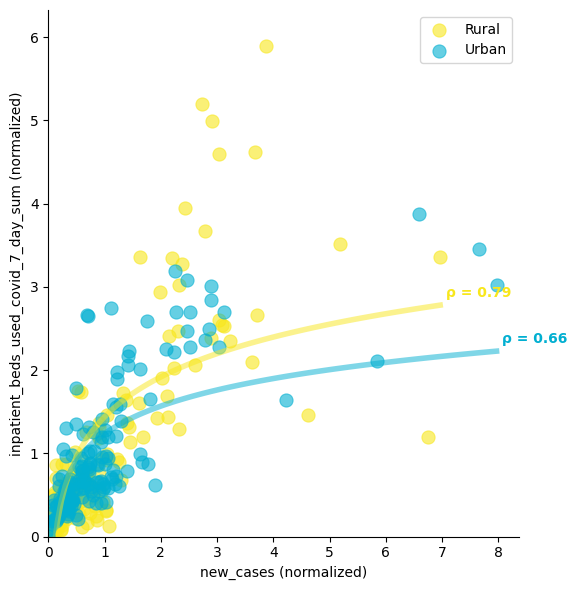

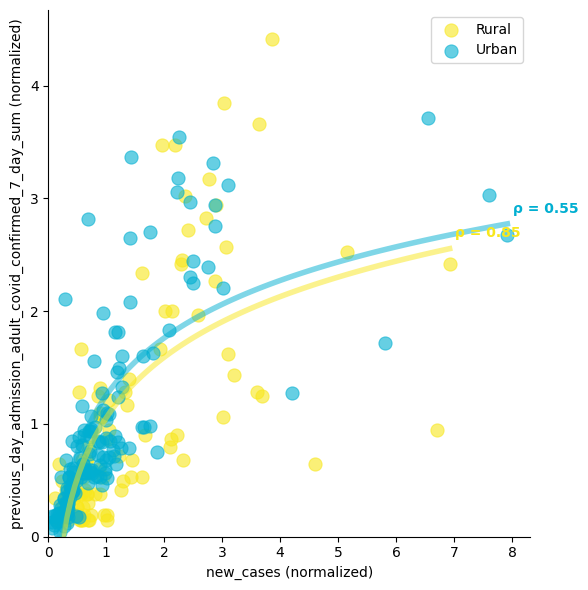

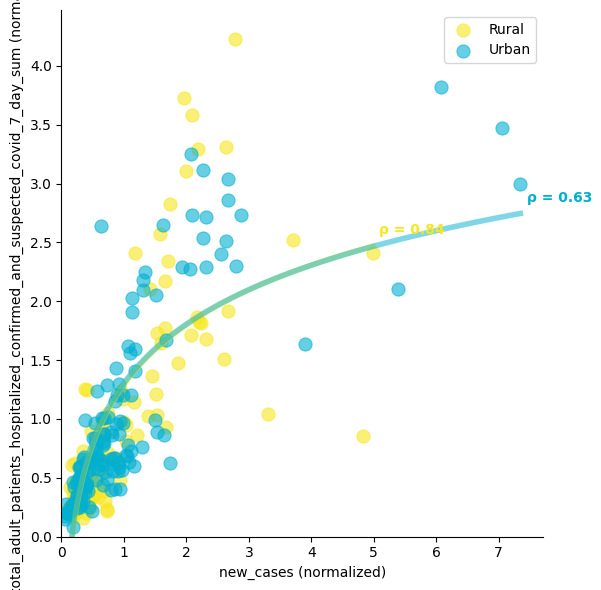

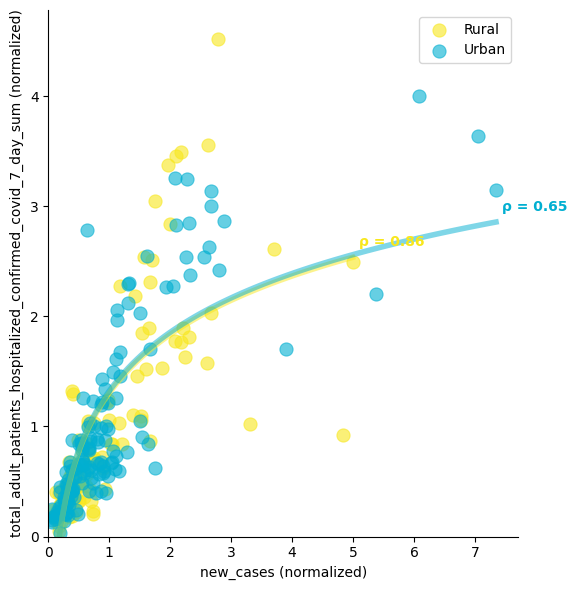

In [376]:
merged_df_MI, high_correlation_columns_rural_MI, high_correlation_columns_urban_MI, corr_matrix_sub_MI = main(df_d, df_h, county_df, columns_d, columns_h, 'MI', display_corr_charts=True)


creating sub hospital dataframe for MI
NaN values present and being replaced with zeros

sub dataframe complete

creating sub covid cases/deaths dataframe for MI

sub dataframe complete

aggregating hospital data


,year,week,is_metro_micro,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,...,previous_day_admission_pediatric_covid_confirmed_0_4_7_day_sum,previous_day_admission_pediatric_covid_confirmed_12_17_7_day_sum,previous_day_admission_pediatric_covid_confirmed_5_11_7_day_sum,previous_day_admission_pediatric_covid_confirmed_unknown_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
364,2023,37,0,3556.0,3527.0,3276.0,1490.0,1483.0,10.0,10.0,...,NaN,NaN,NaN,NaN,105.0,NaN,105.0,NaN,105.0,NaN
115,2021,16,1,78145.0,72440.0,64531.0,56339.0,52436.0,11698.0,11451.0,...,NaN,NaN,NaN,NaN,NaN,NaN,181.0,555.0,181.0,713.0
152,2021,35,0,3578.0,3494.0,3144.0,1549.0,1547.0,188.0,188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,9.0,NaN
201,2022,7,1,77127.0,73567.0,69801.0,57713.0,54758.0,4929.0,4772.0,...,13.0,NaN,4.0,NaN,441.0,25.0,441.0,366.0,441.0,452.0
309,2023,9,1,63124.0,58050.0,50269.0,43457.0,38668.0,1995.0,1932.0,...,NaN,NaN,NaN,NaN,309.0,4.0,309.0,584.0,309.0,677.0



aggregating covid cases/deaths data


,year,week,is_metro_micro,new_cases,new_deaths
164,2021,33,0,87705,1149
61,2020,34,1,3801440,56639
22,2020,15,0,17323,1046
17,2020,12,1,153323,3356
233,2022,15,1,6067413,49442



merging dataframes on week, year, and is_metro_micro
The shape of the merged_df is 328 by 75

shifting data by 1 week


,is_metro_micro,new_cases,new_deaths,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,...,all_pediatric_inpatient_bed_occupied_7_day_coverage,all_pediatric_inpatient_bed_occupied_7_day_sum,all_pediatric_inpatient_beds_7_day_coverage,all_pediatric_inpatient_beds_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
date,,,,,,,,,,,,,,,,,,,,,
2020-03-02,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,1.0,2885,0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,1.0,198,0,574.0,NaN,NaN,470.0,NaN,28.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,0.0,153323,3356,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,1.0,3126,204,8605.0,NaN,NaN,4832.0,NaN,466.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



finding high correlating columns to covid cases and deaths

checking if found high correlation columns are normally distributed
None of the rural data is normally distributed (reject H0)
None of the urban data is normally distributed (reject H0)
None of the data is normally distributed, rerunning the correlation with spearman method

Highly correlated columns for RURAL areas and NEW CASES:
---
inpatient_beds_used_covid_7_day_sum has 162 data points
previous_day_admission_adult_covid_confirmed_7_day_sum has 107 data points
total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum has 147 data points
total_adult_patients_hospitalized_confirmed_covid_7_day_sum has 147 data points

Highly correlated columns for RURAL areas and NEW DEATHS:
---
No highly correlated columns found

Highly correlated columns for URBAN areas and NEW CASES:
---
inpatient_beds_used_covid_7_day_sum has 163 data points
previous_day_admission_adult_covid_confirmed_7_day_sum has 146 data points
total_

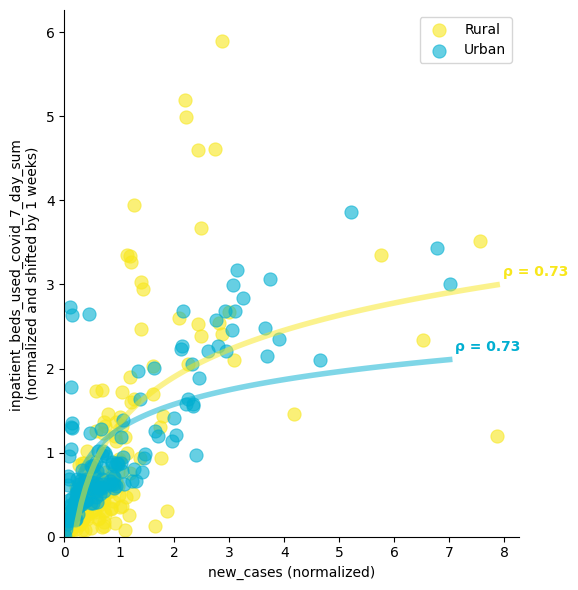

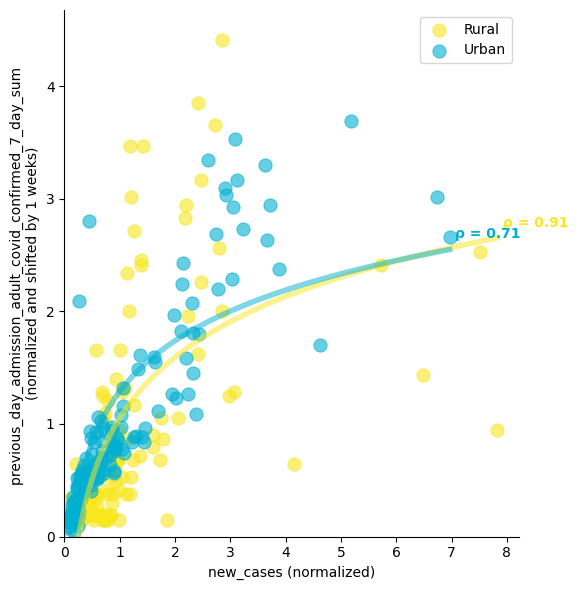

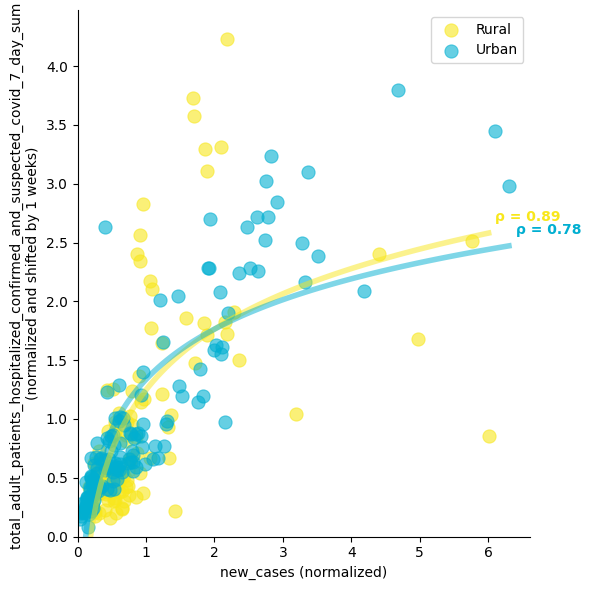

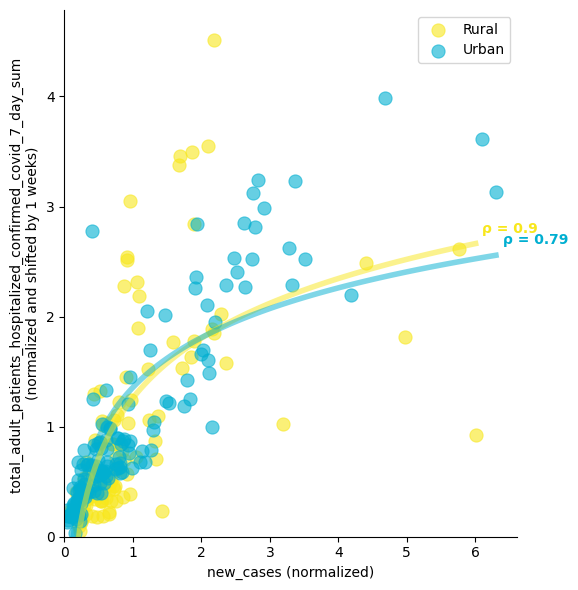

In [365]:
merged_df_MI, high_correlation_columns_rural_MI, high_correlation_columns_urban_MI, corr_matrix_sub_MI = main(df_d, df_h, county_df, columns_d, columns_h, 'MI', shift=1, display_corr_charts=True)


creating sub hospital dataframe for MI
NaN values present and being replaced with zeros

sub dataframe complete

creating sub covid cases/deaths dataframe for MI

sub dataframe complete

aggregating hospital data


,year,week,is_metro_micro,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,...,previous_day_admission_pediatric_covid_confirmed_0_4_7_day_sum,previous_day_admission_pediatric_covid_confirmed_12_17_7_day_sum,previous_day_admission_pediatric_covid_confirmed_5_11_7_day_sum,previous_day_admission_pediatric_covid_confirmed_unknown_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
293,2023,1,1,60329.0,56964.0,52290.0,47590.0,44812.0,3352.0,3289.0,...,NaN,NaN,NaN,NaN,306.0,NaN,306.0,321.0,306.0,453.0
168,2021,43,0,2960.0,2954.0,2274.0,941.0,940.0,271.0,271.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN
207,2022,10,1,62391.0,57341.0,52454.0,46351.0,41719.0,2089.0,1968.0,...,5.0,NaN,NaN,NaN,343.0,10.0,343.0,737.0,343.0,909.0
185,2021,51,1,82912.0,75118.0,65700.0,59184.0,54132.0,14613.0,14278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,193.0,1236.0,193.0,1770.0
328,2023,19,0,2577.0,2577.0,2275.0,826.0,822.0,17.0,17.0,...,NaN,NaN,NaN,NaN,98.0,NaN,98.0,NaN,98.0,NaN



aggregating covid cases/deaths data


,year,week,is_metro_micro,new_cases,new_deaths
320,2023,7,0,39694,294
118,2021,10,0,132045,772
260,2022,29,0,99724,1891
92,2020,50,0,461310,12870
264,2022,31,0,136279,995



merging dataframes on week, year, and is_metro_micro
The shape of the merged_df is 328 by 75

shifting data by 2 week(s)


,is_metro_micro,new_cases,new_deaths,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,...,all_pediatric_inpatient_bed_occupied_7_day_coverage,all_pediatric_inpatient_bed_occupied_7_day_sum,all_pediatric_inpatient_beds_7_day_coverage,all_pediatric_inpatient_beds_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
date,,,,,,,,,,,,,,,,,,,,,
2020-03-02,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,NaN,2885,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,1.0,198,0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,1.0,153323,3356,574.0,NaN,NaN,470.0,NaN,28.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,0.0,3126,204,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



finding high correlating columns to covid cases and deaths

checking if found high correlation columns are normally distributed
None of the rural data is normally distributed (reject H0)
None of the urban data is normally distributed (reject H0)
None of the data is normally distributed, rerunning the correlation with spearman method

Highly correlated columns for RURAL areas and NEW CASES:
---
inpatient_beds_used_covid_7_day_sum has 161 data points
previous_day_admission_adult_covid_confirmed_7_day_sum has 107 data points
staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum has 106 data points
staffed_icu_adult_patients_confirmed_covid_7_day_sum has 103 data points
total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum has 146 data points
total_adult_patients_hospitalized_confirmed_covid_7_day_sum has 146 data points

Highly correlated columns for RURAL areas and NEW DEATHS:
---
total_adult_patients_hospitalized_confirmed_covid_7_day_sum has 146 data p

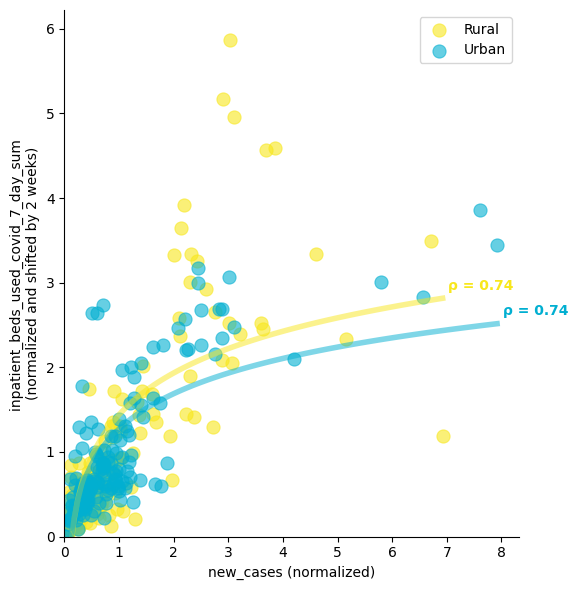

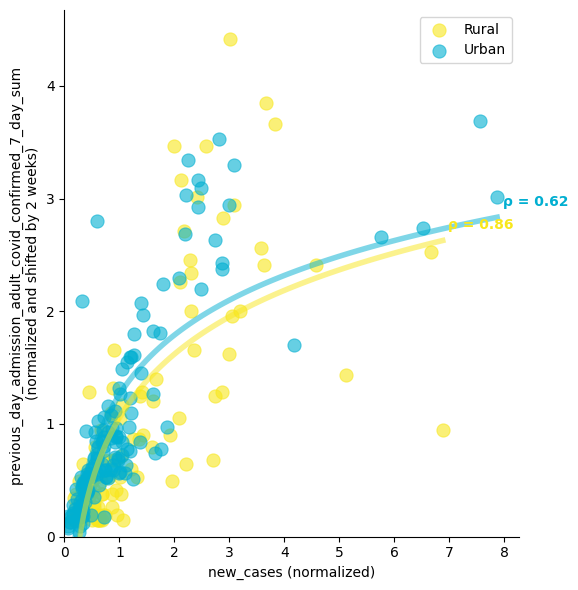

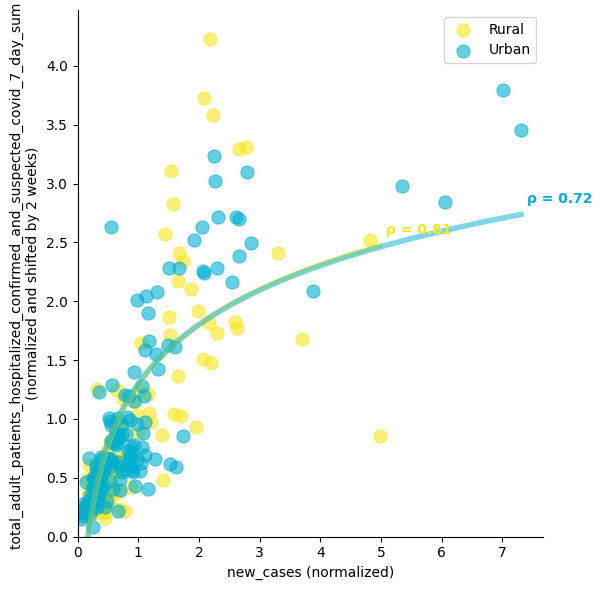

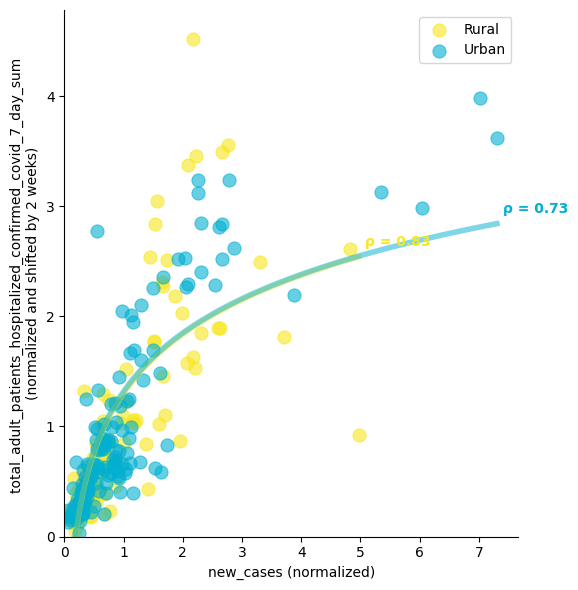

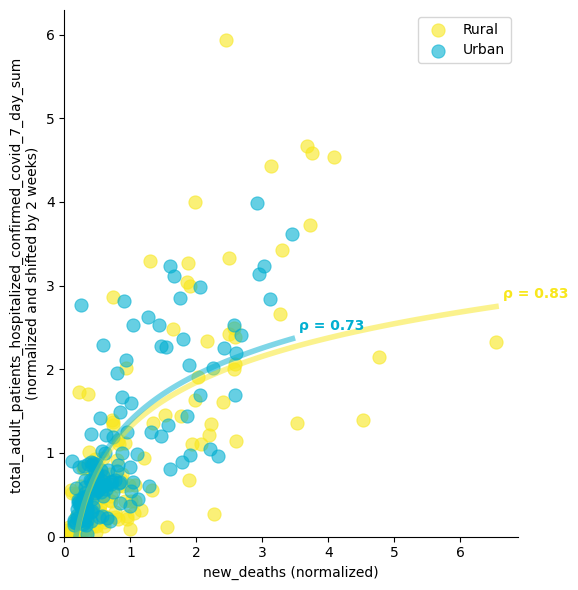

In [371]:
merged_df_MI, high_correlation_columns_rural_MI, high_correlation_columns_urban_MI, corr_matrix_sub_MI = main(df_d, df_h, county_df, columns_d, columns_h, 'MI', shift=2, display_corr_charts=True)

In [33]:
merged_df_NY, high_correlation_columns_rural_NY, high_correlation_columns_urban_NY = main(df_d, df_h, county_df, columns_d, columns_h, state='NY')


creating sub hospital dataframe for NY


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[date_col] = pd.to_datetime(df_sub[date_col])
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['year'] = df_sub[date_col].dt.year
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

NaN values present and being replaced with zeros


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[columns_to_filter] = df_sub[columns_to_filter].fillna(0)
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sub[columns_to_filter] = df_sub[columns_to_filter].applymap(lambda x: max(0, x))
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-


sub dataframe complete

creating sub covid cases/deaths dataframe for NY


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[columns_to_filter] = df_sub[columns_to_filter].applymap(lambda x: max(0, x))



sub dataframe complete

aggregating hospital data


,year,week,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,previous_day_admission_pediatric_covid_confirmed_unknown_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_avg,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_avg,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_avg,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
261,2022,38,0,64.0,64.0,214.0,108.8,108.8,NaN,NaN,...,NaN,NaN,42.0,NaN,NaN,42.0,NaN,NaN,42.0,NaN
309,2023,10,0,64.0,64.0,189.0,93.7,93.7,NaN,NaN,...,NaN,NaN,49.0,NaN,NaN,49.0,NaN,NaN,49.0,NaN
262,2022,38,1,12655.5,11088.8,22710.2,19355.5,17930.5,1426.2,1383.8,...,NaN,NaN,546.0,34.0,182.2,546.0,1389.0,255.7,546.0,1811.0
46,2020,34,1,24780.7,20534.4,15869.4,13865.8,11141.3,725.0,653.6,...,NaN,NaN,386.0,NaN,321.7,371.0,2213.0,336.0,370.0,2294.0
355,2023,33,0,NaN,NaN,46.0,18.3,18.3,NaN,NaN,...,NaN,NaN,21.0,NaN,NaN,21.0,NaN,NaN,21.0,NaN



aggregating covid cases/deaths data


,year,week,is_metro_micro,new_cases,new_deaths
285,2022,41,1,18733712,118426
271,2022,34,1,23621509,117563
99,2020,53,1,47979878,526745
22,2020,15,0,45034,1425
238,2022,18,0,113798,178



merging dataframes on week, year, and is_metro_micro
The shape of the merged_df is 327 by 98


,is_metro_micro,new_cases,new_deaths,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,all_pediatric_inpatient_beds_7_day_sum,previous_day_admission_pediatric_covid_confirmed_0_4_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_avg,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_avg,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
date,,,,,,,,,,,,,,,,,,,,,
2020-03-09,1,9710,0,75.0,NaN,NaN,68.0,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,1,193239,685,1972.3,NaN,NaN,1506.9,NaN,172.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,1,2019428,42618,1079.0,NaN,NaN,513.6,NaN,133.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,0,9054,89,64.0,NaN,NaN,10.7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,1,23821644,434181,17197.7,NaN,NaN,11020.1,NaN,6304.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



finding high correlating columns to covid cases and deaths

checking if found high correlation columns are normally distributed
None of the rural data is normally distributed (reject H0)
None of the urban data is normally distributed (reject H0)

All highly correlated columns for RURAL AREAs:
---
previous_week_personnel_covid_vaccinated_doses_administered_7_day has 31 data points

All highly correlated columns for URBAN AREAs:
---
staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg has 146 data points
staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum has 147 data points
staffed_icu_adult_patients_confirmed_covid_7_day_avg has 144 data points
staffed_icu_adult_patients_confirmed_covid_7_day_sum has 147 data points
total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg has 148 data points
total_adult_patients_hospitalized_confirmed_covid_7_day_avg has 147 data points
total_adult_patients_hospitalized_confirmed_covid_7_day_sum has 151 da

In [34]:
merged_df_WA, high_correlation_columns_rural_WA, high_correlation_columns_urban_WA = main(df_d, df_h, county_df, columns_d, columns_h, state='WA')


creating sub hospital dataframe for WA


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[date_col] = pd.to_datetime(df_sub[date_col])
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['year'] = df_sub[date_col].dt.year
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

NaN values present and being replaced with zeros


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[columns_to_filter] = df_sub[columns_to_filter].fillna(0)
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sub[columns_to_filter] = df_sub[columns_to_filter].applymap(lambda x: max(0, x))
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-


sub dataframe complete

creating sub covid cases/deaths dataframe for WA


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[columns_to_filter] = df_sub[columns_to_filter].applymap(lambda x: max(0, x))



sub dataframe complete

aggregating hospital data


,year,week,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,previous_day_admission_pediatric_covid_confirmed_unknown_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_avg,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_avg,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_avg,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
355,2023,31,1,NaN,NaN,3656.4,3452.2,3162.1,64.9,64.6,...,NaN,NaN,266.0,NaN,6.0,266.0,56.0,10.4,266.0,100.0
250,2022,31,0,NaN,NaN,107.3,46.9,46.9,NaN,NaN,...,NaN,NaN,56.0,NaN,NaN,56.0,NaN,NaN,56.0,NaN
299,2023,3,1,2504.4,2358.2,4920.4,4330.9,4120.1,214.8,214.2,...,NaN,NaN,238.0,NaN,22.3,238.0,174.0,58.9,238.0,412.0
207,2022,9,1,5676.2,4736.9,3887.0,3746.9,3268.8,234.1,206.5,...,NaN,NaN,252.0,21.0,59.4,252.0,416.0,71.4,252.0,500.0
43,2020,31,1,4577.5,3287.0,2914.2,2414.0,3134.1,235.6,214.3,...,NaN,NaN,225.0,7.0,103.6,226.0,471.0,156.4,159.0,1095.0



aggregating covid cases/deaths data


,year,week,is_metro_micro,new_cases,new_deaths
7,2020,7,1,0,0
88,2020,48,0,55656,1248
63,2020,35,1,2764005,32736
323,2023,8,1,3381294,38198
190,2021,46,0,62052,2328



merging dataframes on week, year, and is_metro_micro
The shape of the merged_df is 330 by 93


,is_metro_micro,new_cases,new_deaths,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,all_pediatric_inpatient_beds_7_day_avg,all_pediatric_inpatient_beds_7_day_coverage,all_pediatric_inpatient_beds_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_avg,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_avg,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,1,0,0,317.0,NaN,NaN,223.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,1,69665,17375,333.0,NaN,NaN,214.3,NaN,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,1,455114,24883,333.0,NaN,NaN,205.0,NaN,31.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,0,768,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



finding high correlating columns to covid cases and deaths

checking if found high correlation columns are normally distributed
None of the rural data is normally distributed (reject H0)
None of the urban data is normally distributed (reject H0)

All highly correlated columns for RURAL AREAs:
---

All highly correlated columns for URBAN AREAs:
---
previous_day_admission_adult_covid_confirmed_70-79_7_day_sum has 125 data points


In [35]:
merged_df_TX, high_correlation_columns_rural_TX, high_correlation_columns_urban_TX = main(df_d, df_h, county_df, columns_d, columns_h, state='TX')


creating sub hospital dataframe for TX


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[date_col] = pd.to_datetime(df_sub[date_col])
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['year'] = df_sub[date_col].dt.year
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

NaN values present and being replaced with zeros


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[columns_to_filter] = df_sub[columns_to_filter].fillna(0)
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sub[columns_to_filter] = df_sub[columns_to_filter].applymap(lambda x: max(0, x))
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-


sub dataframe complete

creating sub covid cases/deaths dataframe for TX


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sub[columns_to_filter] = df_sub[columns_to_filter].applymap(lambda x: max(0, x))
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[columns_to_filter] = df_sub[columns_to_filter].applymap(lambda x: max(0, x))



sub dataframe complete

aggregating hospital data


,year,week,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,previous_day_admission_pediatric_covid_confirmed_unknown_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_avg,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_avg,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_avg,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
277,2022,41,0,1376.4,1327.9,1081.9,280.7,278.1,NaN,NaN,...,NaN,NaN,315.0,NaN,NaN,315.0,NaN,NaN,315.0,NaN
120,2021,14,1,31884.8,30108.9,26977.6,20762.5,19334.7,1512.4,1482.6,...,NaN,NaN,NaN,NaN,34.2,105.0,239.0,28.0,105.0,196.0
283,2022,44,0,1139.3,1112.3,894.9,229.7,224.3,NaN,NaN,...,NaN,NaN,260.0,NaN,NaN,260.0,NaN,NaN,260.0,NaN
17,2020,15,0,406.6,NaN,NaN,63.2,NaN,4.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,2022,6,0,889.3,900.5,699.1,151.4,150.2,NaN,NaN,...,NaN,NaN,273.0,NaN,NaN,273.0,NaN,NaN,273.0,NaN



aggregating covid cases/deaths data


,year,week,is_metro_micro,new_cases,new_deaths
97,2020,52,1,190308210,1844166
76,2020,42,0,118407,3414
261,2022,29,1,132611630,159489
120,2021,11,0,74714,3792
294,2022,46,0,33077,744



merging dataframes on week, year, and is_metro_micro
The shape of the merged_df is 333 by 99


,is_metro_micro,new_cases,new_deaths,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,all_pediatric_inpatient_beds_7_day_sum,previous_day_admission_pediatric_covid_confirmed_0_4_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_avg,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_avg,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
date,,,,,,,,,,,,,,,,,,,,,
2020-01-27,1,0,0,32.0,NaN,NaN,10.7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,1,0,0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,1,0,0,36.4,NaN,NaN,27.9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,1,0,0,86.7,NaN,NaN,40.8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,1,0,0,1143.7,NaN,NaN,737.5,NaN,49.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



finding high correlating columns to covid cases and deaths

checking if found high correlation columns are normally distributed
None of the rural data is normally distributed (reject H0)
None of the urban data is normally distributed (reject H0)

All highly correlated columns for RURAL AREAs:
---
inpatient_beds_used_covid_7_day_avg has 80 data points
inpatient_beds_used_covid_7_day_sum has 161 data points
total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg has 70 data points
total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum has 145 data points
total_adult_patients_hospitalized_confirmed_covid_7_day_sum has 144 data points

All highly correlated columns for URBAN AREAs:
---
previous_day_admission_adult_covid_confirmed_20-29_7_day_sum has 136 data points
previous_day_admission_adult_covid_confirmed_60-69_7_day_sum has 146 data points
previous_day_admission_adult_covid_confirmed_70-79_7_day_sum has 146 data points
previous_day_admission_adult

In [36]:
merged_df_FL, high_correlation_columns_rural_FL, high_correlation_columns_urban_FL = main(df_d, df_h, county_df, columns_d, columns_h, state='FL')


creating sub hospital dataframe for FL


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[date_col] = pd.to_datetime(df_sub[date_col])
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['year'] = df_sub[date_col].dt.year
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

NaN values present and being replaced with zeros


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[columns_to_filter] = df_sub[columns_to_filter].fillna(0)
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sub[columns_to_filter] = df_sub[columns_to_filter].applymap(lambda x: max(0, x))
C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-


sub dataframe complete

creating sub covid cases/deaths dataframe for FL


C:\Users\szymo\AppData\Local\Temp\ipykernel_25500\3243894880.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[columns_to_filter] = df_sub[columns_to_filter].applymap(lambda x: max(0, x))



sub dataframe complete

aggregating hospital data


,year,week,is_metro_micro,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,previous_day_admission_pediatric_covid_confirmed_unknown_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_avg,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_avg,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_avg,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
91,2021,4,1,34802.3,31737.0,28572.1,24970.3,23299.9,3637.2,3594.8,...,NaN,NaN,NaN,NaN,761.5,778.0,5446.0,1147.4,778.0,8042.0
394,2023,52,1,12959.8,11907.9,22563.6,19749.1,18304.2,1389.5,1476.4,...,13.0,NaN,658.0,37.0,375.1,658.0,2713.0,579.0,658.0,4106.0
203,2022,8,1,17873.5,16864.6,27050.9,22673.0,21381.7,1188.3,1173.6,...,7.0,NaN,736.0,46.0,178.2,736.0,1414.0,327.5,736.0,2331.0
391,2023,51,0,NaN,NaN,118.0,55.2,55.2,NaN,NaN,...,NaN,NaN,28.0,NaN,NaN,28.0,NaN,NaN,28.0,NaN
69,2020,45,1,30636.3,28184.4,24170.1,21058.1,19612.7,2094.1,2075.4,...,NaN,NaN,1.0,NaN,834.3,679.0,5749.0,1128.3,679.0,7672.0



aggregating covid cases/deaths data


,year,week,is_metro_micro,new_cases,new_deaths
344,2023,19,0,2516,1197
104,2021,3,0,97524,1694
101,2021,1,1,83183307,633695
249,2022,23,1,80638924,108504
126,2021,14,0,7963,301



merging dataframes on week, year, and is_metro_micro
The shape of the merged_df is 328 by 97


,is_metro_micro,new_cases,new_deaths,total_beds_7_day_avg,all_adult_hospital_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_avg,inpatient_beds_used_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,...,all_pediatric_inpatient_beds_7_day_coverage,all_pediatric_inpatient_beds_7_day_sum,staffed_icu_pediatric_patients_confirmed_covid_7_day_coverage,staffed_icu_pediatric_patients_confirmed_covid_7_day_sum,staffed_pediatric_icu_bed_occupancy_7_day_avg,staffed_pediatric_icu_bed_occupancy_7_day_coverage,staffed_pediatric_icu_bed_occupancy_7_day_sum,total_staffed_pediatric_icu_beds_7_day_avg,total_staffed_pediatric_icu_beds_7_day_coverage,total_staffed_pediatric_icu_beds_7_day_sum
date,,,,,,,,,,,,,,,,,,,,,
2020-03-09,1,0,0,45.0,NaN,NaN,10.7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,1,5925,904,45.0,NaN,NaN,9.9,NaN,10.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,1,18660,2968,521.0,NaN,NaN,221.3,NaN,392.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,0,0,0,212.0,NaN,NaN,46.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



finding high correlating columns to covid cases and deaths

checking if found high correlation columns are normally distributed
None of the rural data is normally distributed (reject H0)
None of the urban data is normally distributed (reject H0)

All highly correlated columns for RURAL AREAs:
---
inpatient_beds_used_covid_7_day_sum has 131 data points
total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum has 120 data points
total_adult_patients_hospitalized_confirmed_covid_7_day_sum has 116 data points

All highly correlated columns for URBAN AREAs:
---
previous_day_admission_adult_covid_confirmed_70-79_7_day_sum has 146 data points
previous_day_admission_adult_covid_confirmed_80+_7_day_sum has 146 data points
previous_day_admission_pediatric_covid_confirmed_7_day_sum has 140 data points
total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg has 93 data points
total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum has 147 data points
